In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from lib.datasets.mnistdataset import MNIST500
import torchvision.transforms.functional as tvF
import lib.snn as snn
from datetime import datetime


In [2]:
import matplotlib
#matplotlib.use('Inline')
import matplotlib.pyplot as plt
from tqdm import tqdm

## Prepare Data
* download data, prepare DataLoader
* prepocess:
    1. Color transform. (RGB to YUV; for mnist Grey to RGB to YUV)
        * for mnist, no preprocessing, since it is in gray value
        * for Cifar-10, RGB and scale to [0.0, 1.0]. No abs
        
    2. RandomResizedCrop(size=24) for Cifar-10

In [3]:
def save_model(name, model):
    print("Saving models...")
    model.eval()

    save_model_filename = 'saved_models/' + name + '.pt'

    torch.save(model.state_dict(), save_model_filename)
    
def load_model(name, model):
    model.load_state_dict(torch.load('saved_models/' + name + '.pt'))
    
def test_acc(dataloader ,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels =  data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


In [4]:
BATCH_SIZE  = 4

EPOCH = 100

use_cuda = torch.cuda.is_available()

torch.manual_seed(1024)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
# # MNIST
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,)),
#                        # the Abs was done here
#                        transforms.Lambda(lambda x: x.abs()),
#                    ])),
#     batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=False, 
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,)),
#                        transforms.Lambda(lambda x: x.abs()),
#                    ])),
#     batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [6]:
class Identity(): # used for skipping transforms
    def __call__(self, im):
        return im
    
def transform_cifar(is_train):
    
    return transforms.Compose([
                                transforms.RandomCrop(size=24) if is_train else Identity(),
                                transforms.RandomHorizontalFlip(p=0.5) if is_train else Identity(),
                                transforms.CenterCrop(size=24) if not is_train else Identity(),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                #transforms.Lambda(lambda x: x.abs()),
                            ])

class ConvLayer(torch.nn.Module):
    """
        out = ((in+2*padding-(kernel_size-1)-1)/stride)+1
        
        when kernel_size is: odd number, the output is only affected by stride
                             even number, use the formula.
        
        For example: if kernel size is odd, and with stride 1 then out = in, but
        channel changes. With stride 2, out is halved.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [7]:
# Cifar-10

is_train = True

trainset = MNIST500(datasetPath='./data', train=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

is_train = False

testset = MNIST500(datasetPath='./data', train=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

# Learning stats instance.
stats = snn.learningStats()

In [8]:
data, label = next(iter(trainloader))

In [9]:
torch.max(data[:10])

tensor(1.)

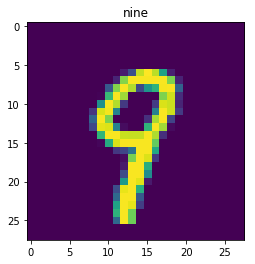

In [10]:
idx = 2
plt.imshow(data[idx].permute(1,2,0).squeeze())
plt.title(classes[label[idx]])
plt.show()

In [31]:
class Raw_CNN(nn.Module):
    def __init__(self):
        super(Raw_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5, padding=1, bias=True)
        self.conv2 = nn.Conv2d(12, 64, 5, padding=1, bias=True)
        self.m1 = nn.MaxPool2d(2)
        self.m2 = nn.MaxPool2d(2,padding=1)
        self.fc1 = nn.Linear(64 * 6 * 6, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #(3, 24, 24) -> (64, 20, 20)
        x = self.m1(x) #(64, 10, 10)
        x = F.relu(self.conv2(x)) #(64, 6, 6)
        x = self.m2(x) #(64, 3, 3)
        x = x.view(-1, 64 * 6 * 6)    #(64*3*3)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

class Tailored_CNN(nn.Module):
    def __init__(self):
        super(Tailored_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5, padding=1, bias=False)
        self.conv2 = nn.Conv2d(12, 64, 5, padding=1, bias=False)
        self.a1 = nn.AvgPool2d(2)
        self.a2 = nn.AvgPool2d(2,padding=1)
        self.fc1 = nn.Linear(64 * 6 * 6, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #(3, 24, 24) -> (64, 20, 20)
        x = self.a1(x) #(64, 10, 10)
        x = F.relu(self.conv2(x)) #(64, 6, 6)
        x = self.a2(x) #(64, 3, 3)
        x = x.view(-1, 64 * 6 * 6)    #(64*3*3)
        x = self.fc1(x) #(10*1*1)
        return F.log_softmax(x, dim=1)

In [32]:
raw_cnn = Raw_CNN().to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(raw_cnn.parameters(), lr=0.001)
stats = snn.learningStats()

## Training

# training loop
for epoch in tqdm(range(EPOCH)):
    # Reset training stats.
    stats.training.reset()
    tSt = datetime.now()
    raw_cnn.train()    
    # Training loop.
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = raw_cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Gather the training stats.
        _, predicted = torch.max(outputs.data, 1)
        
        stats.training.correctSamples += torch.sum(predicted == labels).data.item()
        stats.training.numSamples += len(labels)

        # Display training stats.
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
    # Update training stats.
    stats.training.update()
    # Reset testing stats.
    stats.testing.reset()
    raw_cnn.eval()    
    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = raw_cnn.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)

        stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
        stats.testing.numSamples += len(label)

        loss = criterion(outputs, labels)
        stats.testing.lossSum += loss.cpu().data.item()
        
        # if i%10 == 0: stats.print(epoch, i)


    # Update stats.
    stats.testing.update()
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
print('Finished Training')
save_model('raw_cnn', raw_cnn)

  1%|          | 1/100 [00:00<00:46,  2.14it/s]


Epoch :          0,     467.0160 ms elapsed
loss = 0.30528      (min = 0.30528     )  	accuracy = 0.618      (max = 0.618     )
loss = 0.16188      (min = 0.16188     )  	accuracy = 0.786      (max = 0.786     )


 11%|█         | 11/100 [00:04<00:40,  2.22it/s]


Epoch :         10,     448.1870 ms elapsed
loss = 0.00032371   (min = 0.00032371  )  	accuracy = 1          (max = 1         )
loss = 0.051625     (min = 0.048427    )  	accuracy = 0.936      (max = 0.936     )


 21%|██        | 21/100 [00:09<00:35,  2.22it/s]


Epoch :         20,     451.2590 ms elapsed
loss = 6.8769e-05   (min = 6.8769e-05  )  	accuracy = 1          (max = 1         )
loss = 0.056315     (min = 0.048427    )  	accuracy = 0.938      (max = 0.94      )


 31%|███       | 31/100 [00:13<00:31,  2.21it/s]


Epoch :         30,     448.2110 ms elapsed
loss = 2.3645e-05   (min = 2.3645e-05  )  	accuracy = 1          (max = 1         )
loss = 0.059985     (min = 0.048427    )  	accuracy = 0.936      (max = 0.94      )


 41%|████      | 41/100 [00:18<00:28,  2.11it/s]


Epoch :         40,     459.6230 ms elapsed
loss = 9.0716e-06   (min = 9.0716e-06  )  	accuracy = 1          (max = 1         )
loss = 0.063586     (min = 0.048427    )  	accuracy = 0.94       (max = 0.942     )


 51%|█████     | 51/100 [00:23<00:22,  2.18it/s]


Epoch :         50,     452.5870 ms elapsed
loss = 3.2429e-06   (min = 3.2429e-06  )  	accuracy = 1          (max = 1         )
loss = 0.066026     (min = 0.048427    )  	accuracy = 0.94       (max = 0.942     )


 61%|██████    | 61/100 [00:28<00:17,  2.20it/s]


Epoch :         60,     449.4410 ms elapsed
loss = 1.3142e-06   (min = 1.3142e-06  )  	accuracy = 1          (max = 1         )
loss = 0.068857     (min = 0.048427    )  	accuracy = 0.94       (max = 0.942     )


 71%|███████   | 71/100 [00:32<00:13,  2.20it/s]


Epoch :         70,     455.2570 ms elapsed
loss = 5.6344e-07   (min = 5.6344e-07  )  	accuracy = 1          (max = 1         )
loss = 0.071407     (min = 0.048427    )  	accuracy = 0.94       (max = 0.942     )


 81%|████████  | 81/100 [00:37<00:08,  2.17it/s]


Epoch :         80,     453.1830 ms elapsed
loss = 2.6238e-07   (min = 2.6238e-07  )  	accuracy = 1          (max = 1         )
loss = 0.074122     (min = 0.048427    )  	accuracy = 0.94       (max = 0.942     )


 91%|█████████ | 91/100 [00:41<00:04,  2.19it/s]


Epoch :         90,     452.1500 ms elapsed
loss = 1.2559e-07   (min = 1.2559e-07  )  	accuracy = 1          (max = 1         )
loss = 0.077445     (min = 0.048427    )  	accuracy = 0.942      (max = 0.942     )


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]

Finished Training
Saving models...


In [35]:
test_acc(testloader, raw_cnn)

Accuracy of the network on the 10000 test images: 94 %


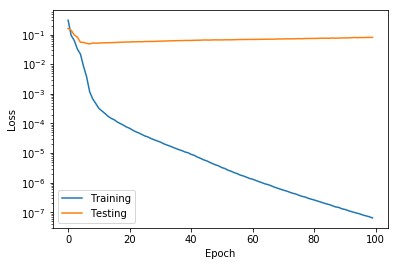

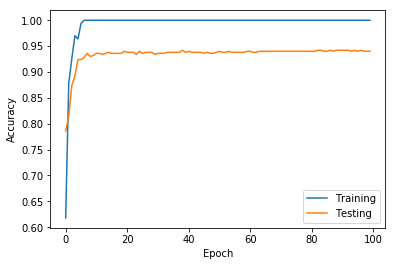

In [36]:
# Plot the results.
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing.lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing.accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
tailored_cnn = Tailored_CNN().to(device)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tailored_cnn.parameters(), lr=0.001)
stats = snn.learningStats()
## Training
# training loop
for epoch in tqdm(range(EPOCH)):
    # Reset training stats.
    stats.training.reset()
    tSt = datetime.now()
    tailored_cnn.train()    
    # Training loop.
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = tailored_cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Gather the training stats.
        _, predicted = torch.max(outputs.data, 1)
        
        stats.training.correctSamples += torch.sum(predicted == labels).data.item()
        stats.training.numSamples += len(labels)

        # Display training stats.
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
    # Update training stats.
    stats.training.update()
    # Reset testing stats.
    stats.testing.reset()
    tailored_cnn.eval()    
    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = tailored_cnn.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)

        stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
        stats.testing.numSamples += len(label)

        loss = criterion(outputs, labels)
        stats.testing.lossSum += loss.cpu().data.item()
        
        # if i%10 == 0: stats.print(epoch, i)


    # Update stats.
    stats.testing.update()
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())

print('Finished Training')
save_model('tailor_cnn', tailored_cnn)

  1%|          | 1/100 [00:00<00:41,  2.39it/s]


Epoch :          0,     418.3760 ms elapsed
loss = 0.33083      (min = 0.33083     )  	accuracy = 0.592      (max = 0.592     )
loss = 0.18405      (min = 0.18405     )  	accuracy = 0.758      (max = 0.758     )


 11%|█         | 11/100 [00:04<00:36,  2.45it/s]


Epoch :         10,     405.5560 ms elapsed
loss = 0.0018167    (min = 0.0018167   )  	accuracy = 0.996      (max = 1         )
loss = 0.06086      (min = 0.053523    )  	accuracy = 0.938      (max = 0.938     )


 21%|██        | 21/100 [00:08<00:32,  2.46it/s]


Epoch :         20,     406.6800 ms elapsed
loss = 0.00010976   (min = 0.00010976  )  	accuracy = 1          (max = 1         )
loss = 0.072515     (min = 0.053523    )  	accuracy = 0.936      (max = 0.942     )


 31%|███       | 31/100 [00:12<00:28,  2.42it/s]


Epoch :         30,     422.0690 ms elapsed
loss = 4.0491e-05   (min = 4.0491e-05  )  	accuracy = 1          (max = 1         )
loss = 0.080962     (min = 0.053523    )  	accuracy = 0.934      (max = 0.942     )


 41%|████      | 41/100 [00:16<00:24,  2.45it/s]


Epoch :         40,     406.1290 ms elapsed
loss = 1.6732e-05   (min = 1.6732e-05  )  	accuracy = 1          (max = 1         )
loss = 0.089868     (min = 0.053523    )  	accuracy = 0.936      (max = 0.942     )


 51%|█████     | 51/100 [00:20<00:20,  2.43it/s]


Epoch :         50,     408.9730 ms elapsed
loss = 7.4465e-06   (min = 7.4465e-06  )  	accuracy = 1          (max = 1         )
loss = 0.096803     (min = 0.053523    )  	accuracy = 0.934      (max = 0.942     )


 61%|██████    | 61/100 [00:25<00:16,  2.31it/s]


Epoch :         60,     436.7510 ms elapsed
loss = 3.5117e-06   (min = 3.5117e-06  )  	accuracy = 1          (max = 1         )
loss = 0.10451      (min = 0.053523    )  	accuracy = 0.932      (max = 0.942     )


 71%|███████   | 71/100 [00:29<00:12,  2.40it/s]


Epoch :         70,     413.6990 ms elapsed
loss = 1.798e-06    (min = 1.798e-06   )  	accuracy = 1          (max = 1         )
loss = 0.11227      (min = 0.053523    )  	accuracy = 0.932      (max = 0.942     )


 81%|████████  | 81/100 [00:33<00:07,  2.40it/s]


Epoch :         80,     411.7170 ms elapsed
loss = 8.2992e-07   (min = 8.2992e-07  )  	accuracy = 1          (max = 1         )
loss = 0.11846      (min = 0.053523    )  	accuracy = 0.932      (max = 0.942     )


 91%|█████████ | 91/100 [00:37<00:03,  2.38it/s]


Epoch :         90,     411.9270 ms elapsed
loss = 4.0316e-07   (min = 4.0316e-07  )  	accuracy = 1          (max = 1         )
loss = 0.12632      (min = 0.053523    )  	accuracy = 0.932      (max = 0.942     )


100%|██████████| 100/100 [00:41<00:00,  2.37it/s]

Finished Training
Saving models...


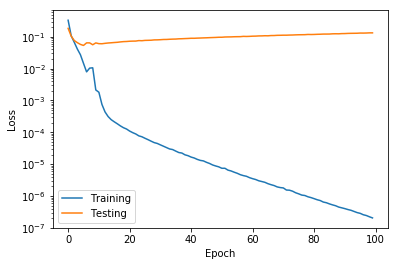

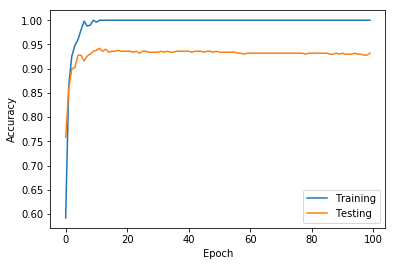

In [42]:
# Plot the results.
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing.lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing.accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
test_acc(testloader, tailored_cnn)

Accuracy of the network on the 10000 test images: 93 %


In [44]:
load_model('tailor_cnn', tailored_cnn)

# how to access the weights for each layer

In [45]:
for k in iter(tailored_cnn.state_dict()):
    print("Layer {}".format(k))
    print(tailored_cnn.state_dict()[k].shape)

Layer conv1.weight
torch.Size([12, 1, 5, 5])
Layer conv2.weight
torch.Size([64, 12, 5, 5])
Layer fc1.weight
torch.Size([10, 2304])


In [38]:
tailored_cnn.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0148,  0.1083,  0.2091,  0.0521,  0.2172],
                        [-0.0428,  0.1968,  0.2187,  0.3102,  0.1050],
                        [-0.0264,  0.0270,  0.2343,  0.4080,  0.3028],
                        [ 0.1264, -0.1512,  0.0053,  0.0594,  0.3287],
                        [-0.2567, -0.1848,  0.0199,  0.2736,  0.1826]]],
              
              
                      [[[-0.0434,  0.0501, -0.0453, -0.0645, -0.0099],
                        [ 0.1126,  0.0540, -0.1087,  0.1727, -0.0813],
                        [ 0.0325,  0.2856,  0.3630, -0.0363, -0.0229],
                        [ 0.4693,  0.5071,  0.3312,  0.0737,  0.1089],
                        [ 0.3859,  0.4826,  0.2852,  0.2652, -0.0162]]],
              
              
                      [[[-0.0815, -0.1633,  0.0514, -0.1104,  0.1616],
                        [ 0.2045,  0.1866,  0.2127,  0.2451,  0.1226],
                        [ 0.1288,  0.2893,  0.3589,  0